#

# Normal LDM

In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.transforms import GaussianBlur
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, zoom, mean as ndimage_mean
from skimage.transform import resize
import cv2


c:\Users\Varun\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Varun\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Model definition


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [4]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [5]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):

        #print("X:",x.size())
        x = self.up(x)
        #print("X:",x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

In [7]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, latent_channels=4):
        super().__init__()
        # Input: [batch_size, 1, 28, 28] -> Output: [batch_size, 4, 8, 8]
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2)  # 14x14 -> 8x8
        self.conv3 = nn.Conv2d(64, latent_channels, kernel_size=3, padding=1)  # 8x8 -> 8x8
        
        self.norm1 = nn.GroupNorm(8, 32)
        self.norm2 = nn.GroupNorm(8, 64)
        self.norm3 = nn.GroupNorm(1, latent_channels)
        self.act = nn.SiLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act(x)
        
        x = self.conv3(x)
        x = self.norm3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_channels=4, out_channels=1):
        super().__init__()
        # Decoder architecture
        # Input: [batch_size, 4, 8, 8] -> Output: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(latent_channels, 64, kernel_size=3, padding=1)  # 8x8
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=2)  # 14x14
        self.conv3 = nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1)  # 28x28
        
        self.norm1 = nn.GroupNorm(8, 64)
        self.norm2 = nn.GroupNorm(8, 32)
        self.act = nn.SiLU()
        
    def forward(self, x):
        # First convolution maintains spatial dimensions
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act(x)
        #print("X_1:",x.size())
        
        # First upsample: 8x8 -> 16x16
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act(x)
        #print("X_2:",x.size())
        
        # Second upsample: 16x16 -> 28x28
        x = self.conv3(x)
        #print("X_3:",x.size())
        return torch.tanh(x)  # normalize output to [-1, 1]

In [9]:
# Initialize model
latent_channels = 4

encoder = Encoder(in_channels=1,latent_channels=latent_channels).to(device)
decoder = Decoder(latent_channels=latent_channels,out_channels=1).to(device)
unet = UNet(c_in=latent_channels,c_out=latent_channels).to(device)


# Create optimizer for autoencoder only




In [10]:
# Test the dimensions
with torch.no_grad():
    test_input = torch.randn(2, 1, 28, 28).to(device)
    latent = encoder(test_input)
    #latent = test_input
    print("Latent shape:", latent.shape)  # Should be [2, 4, 7, 7]
    unet_out = unet(latent, torch.ones(2).to(device))
    print("UNet output shape:", unet_out.shape)  # Should also be [2, 4, 7, 7]

Latent shape: torch.Size([2, 4, 8, 8])
UNet output shape: torch.Size([2, 4, 8, 8])


In [25]:
class LatentDiffusionModel(nn.Module):
    def __init__(self, encoder, decoder, diffusion_unet, diffusion):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.unet = diffusion_unet
        self.diffusion = diffusion  # cold diff or normal diff based on the instance sent
        
    def freeze_autoencoder(self):
        """Freeze encoder and decoder weights"""
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False
            
    def unfreeze_autoencoder(self):
        """Unfreeze encoder and decoder weights"""
        for param in self.encoder.parameters():
            param.requires_grad = True
        for param in self.decoder.parameters():
            param.requires_grad = True

    def forward(self, x, t):

        z = self.encoder(x)         # encode to latent
        #plot_images(z)
        z_noised = self.diffusion.degradation(z, t)  # apply diffusion noise in latent space
        #plot_images(z_noised)
        z_denoised = self.unet(z_noised, t)
        #plot_images(z_denoised)
        x_recon = self.decoder(z_denoised)

        return x_recon
    
    def encode(self, x):
        """Encode images to latent space"""
        return self.encoder(x)
    
    def decode(self, z):
        """Decode from latent space to image space"""
        return self.decoder(z)
    
    def autoencoder_forward(self, x):
        """Forward pass through just the autoencoder"""
        z = self.encoder(x)
        return self.decoder(z)



In [26]:
class Diffusion:
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device=device):
        self.steps = steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1-self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0) #cumulative product.
        
    def prepare_noise_schedule(self, mode='linear'):
        if mode=='linear':
            return torch.linspace(self.beta_start, self.beta_end, self.steps)
        if mode=='cos':
            #TODO : open ai cos schedule
            pass
        
    def noise_images(self, x, t):
        # Generate X_t in a single step as described in the paper
        # x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*e
        e = torch.randn_like(x)
        x_t = x*torch.sqrt(self.alpha_hat[t])[:, None, None, None] + torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]*e # ?
        return x_t, e
        
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,))
    
    def sample(self, model, n):
        model.eval()
        # Algo 2 - Sampling
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i>1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1/torch.sqrt(alpha)*(x-((1-alpha)/torch.sqrt(1-alpha_hat))*predicted_noise)+torch.sqrt(beta)*noise
            model.train()
            x = (x.clamp(-1,1)+1)/2
            x = (x*255).type(torch.uint8)
            return x

    def degradation(self, x, t):
        # Returns noised image x_t and noise e
        x_t,e = self.noise_images(x,t)
        return x_t


In [27]:
# Initialize model
latent_channels = 4

encoder = Encoder(in_channels=1,latent_channels=latent_channels).to(device)
decoder = Decoder(latent_channels=latent_channels,out_channels=1).to(device)
unet = UNet(c_in=latent_channels,c_out=latent_channels).to(device)
diffusion = Diffusion()





ldm = LatentDiffusionModel(encoder, decoder, unet, diffusion).to(device)

# Create optimizer for autoencoder only




In [28]:
# Test the dimensions
with torch.no_grad():
    test_input = torch.randn(2, 1, 28, 28).to(device)
    latent = encoder(test_input)
    print("Latent shape:",latent.shape)
    unet_out = unet(latent, torch.ones(2).to(device))
    print("UNet output shape:", unet_out.shape)  # Should also be [2, 4, 7, 7]
    recon = decoder(unet_out)
    print("Recon shape:", recon.shape)




Latent shape: torch.Size([2, 4, 8, 8])
UNet output shape: torch.Size([2, 4, 8, 8])
Recon shape: torch.Size([2, 1, 28, 28])


# Training setup

In [29]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.Resize((28, 28)),    # Resize to 28x28 for MNIST
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [30]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.detach().cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [31]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [38]:
autoencoder_epochs = 10
diffusion_epochs = 50

batch_size = 128
image_size = 28
learning_rate = 5e-5
loss_type = 'L1' # 'L1', 'L2', 'SmoothL1', 'Huber'
sampling_type = 'gmm' # 'random', 'black', 'real_degraded', 'gmm'

# DEGRADATION TYPE
degradation_type = 'blur' # 'blur', 'pixellate', 'inpainting', 'snow', 'gaussian'

# Steps for diffusion process - changes based on the function used
# For pixellate, steps = 4 (MNIST) or 6 (CIFAR10)
steps = 100

FASHION_MNIST = False

# Import dataset
if (FASHION_MNIST):
    dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transforms, download=True)
else:
    dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

# LIMIT THE DATASET
LIMIT = True
if LIMIT:
    num_samples = 6000
    dataset = torch.utils.data.Subset(dataset, range(num_samples))
    test_dataset = torch.utils.data.Subset(test_dataset, range(num_samples//6))

    print("LIMITED DATASET")
    print(len(dataset))
    print(len(test_dataset))

else:
    print("FULL DATASET")
    print(len(dataset))
    print(len(test_dataset))
# dataset = torch.utils.data.Subset(dataset, range(1000))
# test_dataset = torch.utils.data.Subset(test_dataset, range(1000))


train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)




autoencoder_optimizer = torch.optim.Adam(
    list(ldm.encoder.parameters()) + list(ldm.decoder.parameters()),
    lr=1e-4)

diffusion_optimizer = torch.optim.Adam(ldm.unet.parameters(), lr=1e-4)

# Create optimizer for diffusion model only

autoencoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(autoencoder_optimizer, factor=0.5, patience=5)
diffusion_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(diffusion_optimizer, factor=0.5, patience=5)



if loss_type == 'L1':
    loss_fn = nn.L1Loss()
elif loss_type == 'L2':
    loss_fn = nn.MSELoss()
elif loss_type == 'SmoothL1':
    loss_fn = nn.SmoothL1Loss()
elif loss_type == 'Huber':
    loss_fn = nn.HuberLoss()
elif loss_type == 'BCE':
    loss_fn = nn.BCEWithLogitsLoss()
else:
    raise ValueError("Invalid loss type. Choose from 'L1', 'L2', 'SmoothL1', 'Huber' or 'BCE'.")

reconstruction_loss = nn.MSELoss()

length = len(train_loader)
print(length)

train_losses = []
val_losses = []



LIMITED DATASET
6000
1000
47


# Visualize degradations

tensor([760, 491, 457, 531, 504, 955, 513, 890, 833, 326, 960, 487, 463, 300,
        843, 174, 597, 544,  38, 874,  81, 900, 249, 142, 541, 861, 857, 340,
         91,  41, 928, 136, 552, 811, 953, 963, 612, 232, 548, 985, 950, 174,
        438, 538, 768, 287, 246, 469, 975, 452, 861, 423, 914, 680, 186,  29,
        926, 180, 400,  56,  22, 412,  98, 562, 829, 526, 768,  14, 732, 281,
        196, 187, 524, 207, 190, 144, 681, 687, 765, 857, 199, 965, 257, 297,
        529, 569, 372, 435, 171, 258, 663, 632, 378, 581, 209, 967, 715, 431,
        430, 619,  87, 946, 967, 687, 751, 994,   6,   7,  24, 745, 381, 645,
        370, 247, 990,  98, 441, 123, 270, 582, 662, 334, 964, 147,  90, 734,
        945, 124]) torch.Size([128])


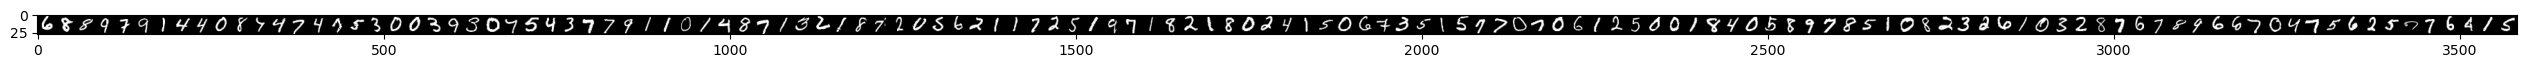

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


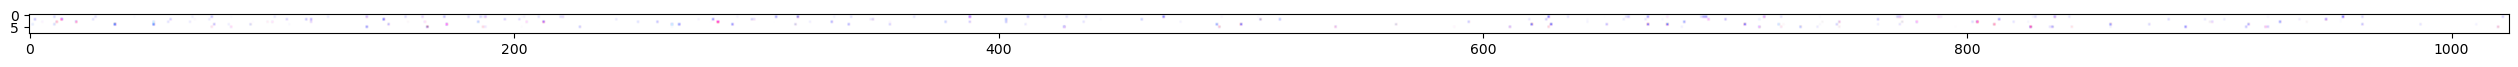

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


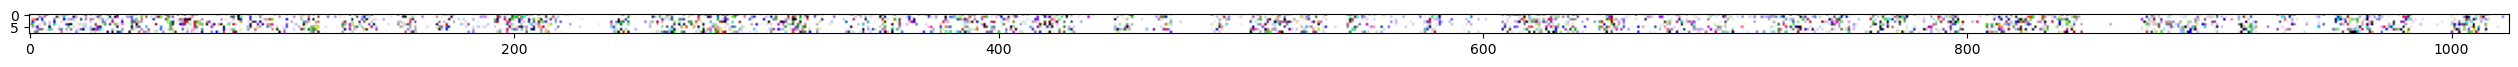

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


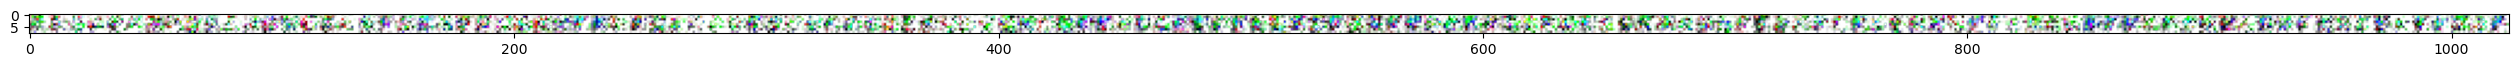

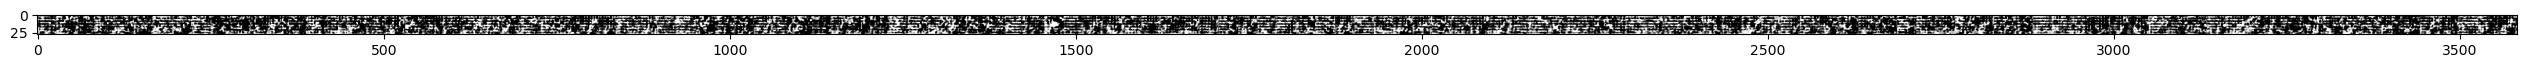

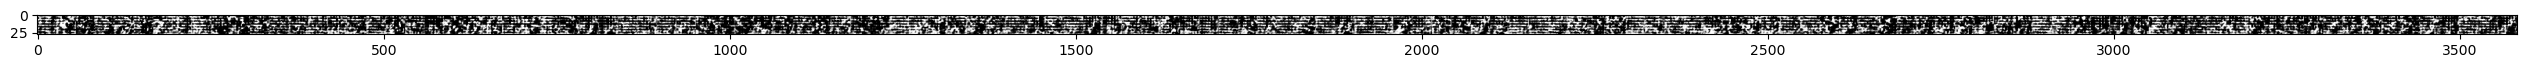

In [39]:
for x, _ in train_loader:
    x = x.to(device)
    t = diffusion.sample_timesteps(x.shape[0])
    print(t,t.shape)
    # Plot the images
    
    plot_images(x)

    z = ldm.encode(x)
    plot_images(z)

    z_noised = ldm.diffusion.degradation(z,t)
    plot_images(z_noised)


    z_denoised = ldm.unet(z_noised,t)
    plot_images(z_denoised)

    x_recon = ldm.decoder(z_denoised)
    plot_images(x_recon)



    x_t = ldm(x,t)


    plot_images(x_t)
    break

# Autoencoder training loop

Starting Autoencoder Training...
Epoch 1 Validation Loss: 0.022016


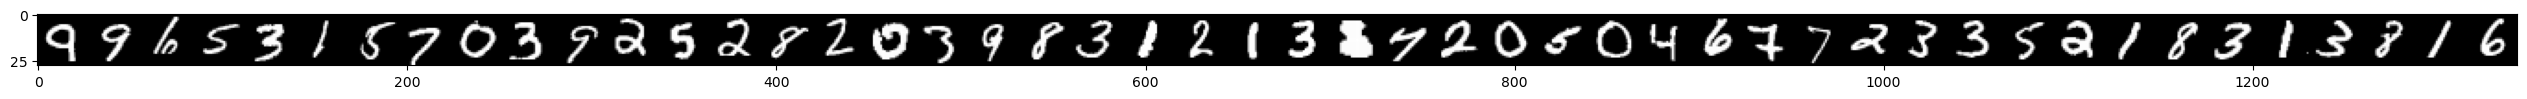

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


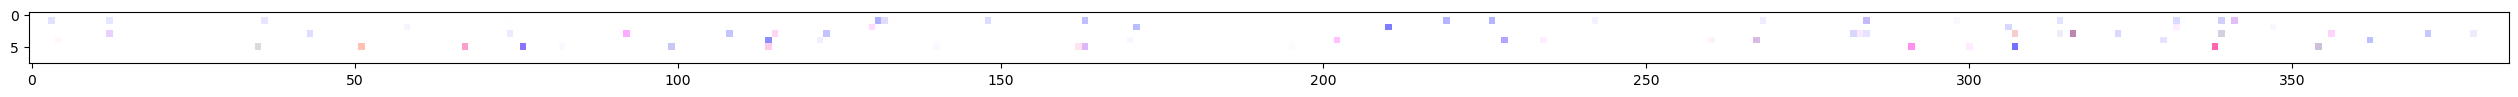

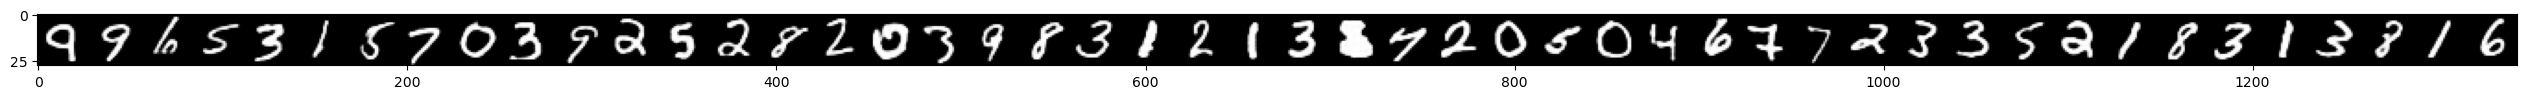

--------------------------------------------------
Epoch 2 Validation Loss: 0.021840
--------------------------------------------------
Epoch 3 Validation Loss: 0.021721
--------------------------------------------------
Epoch 4 Validation Loss: 0.021681
--------------------------------------------------
Epoch 5 Validation Loss: 0.021918
--------------------------------------------------
Epoch 6 Validation Loss: 0.021920


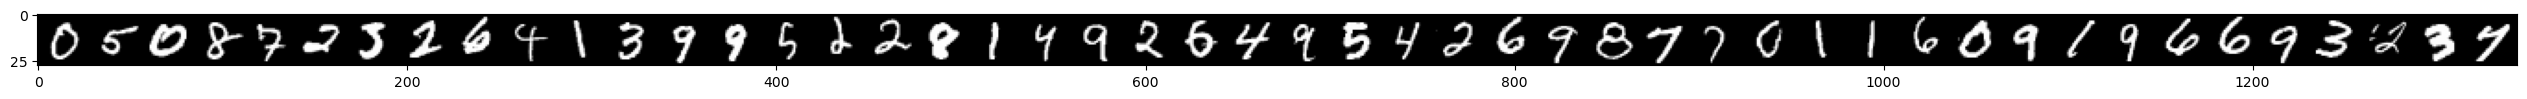

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


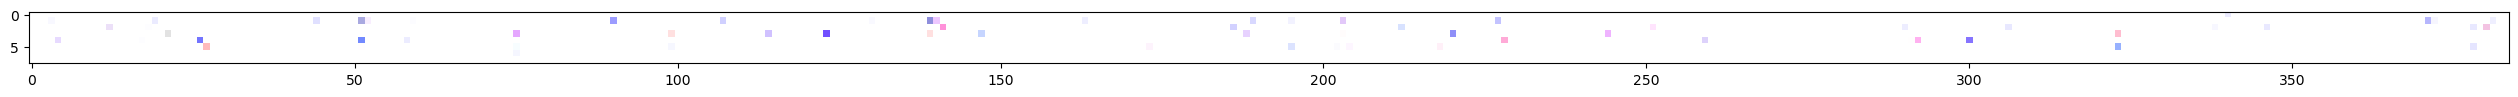

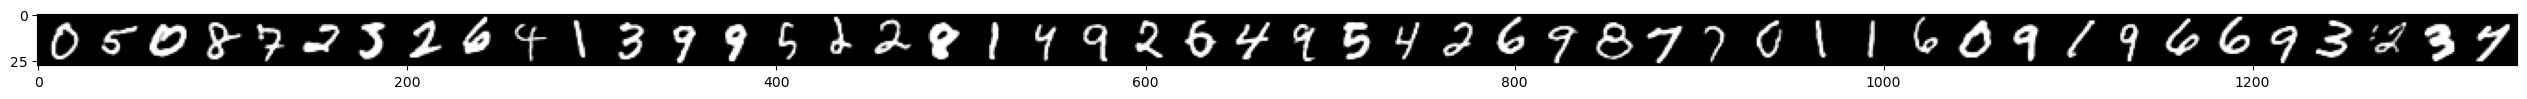

--------------------------------------------------
Epoch 7 Validation Loss: 0.021409
--------------------------------------------------
Epoch 8 Validation Loss: 0.021119
--------------------------------------------------
Epoch 9 Validation Loss: 0.021288
--------------------------------------------------
Epoch 10 Validation Loss: 0.020960
--------------------------------------------------
Epoch 11 Validation Loss: 0.020975


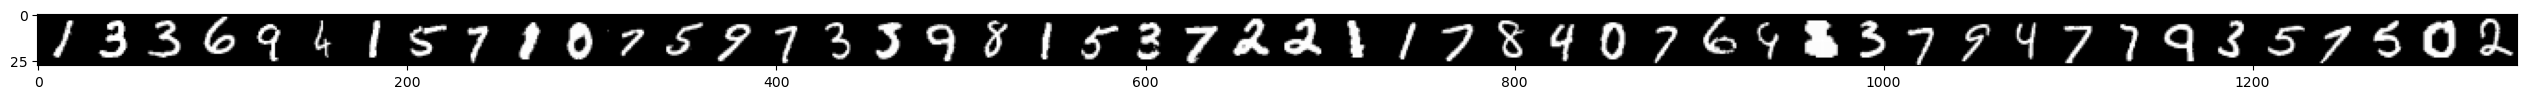

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


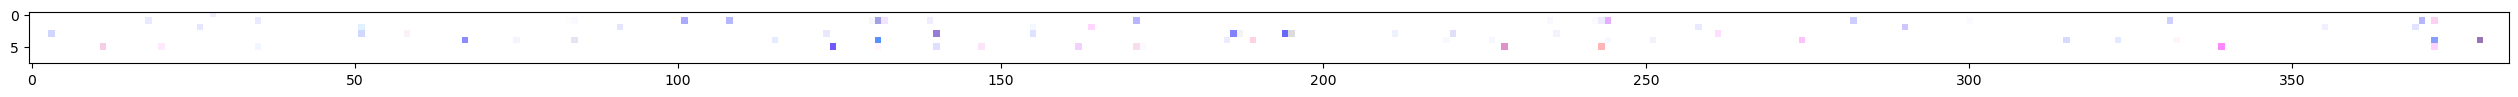

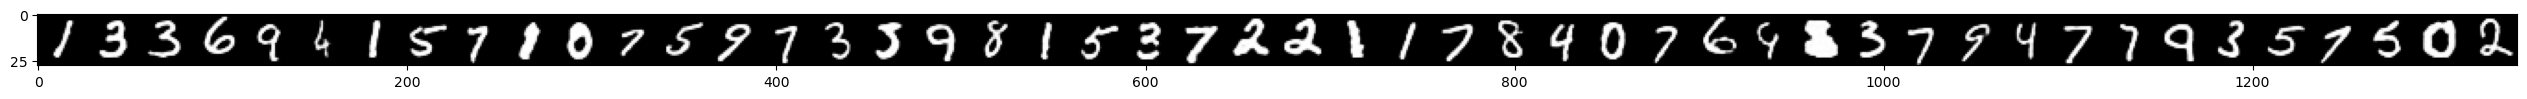

--------------------------------------------------
Epoch 12 Validation Loss: 0.020651
--------------------------------------------------
Epoch 13 Validation Loss: 0.020909
--------------------------------------------------
Epoch 14 Validation Loss: 0.020789
--------------------------------------------------
Epoch 15 Validation Loss: 0.020489
--------------------------------------------------
Epoch 16 Validation Loss: 0.021019


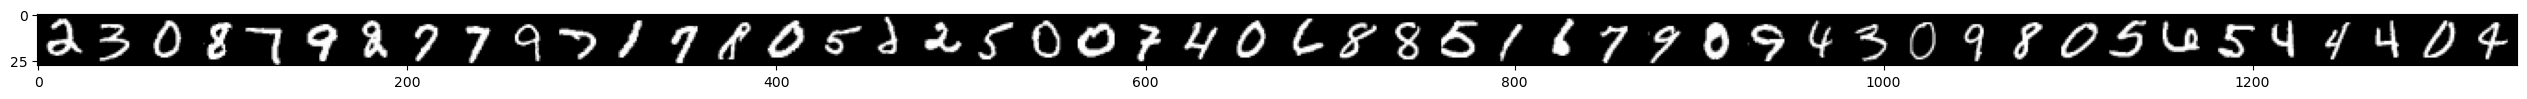

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


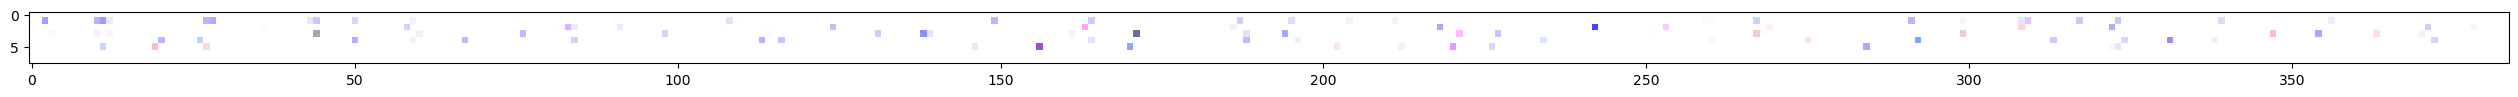

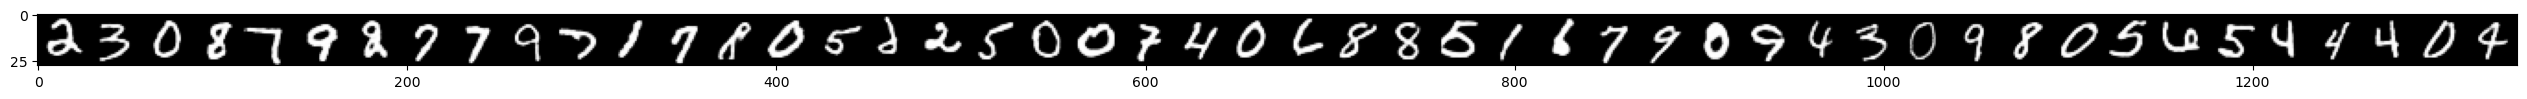

--------------------------------------------------
Epoch 17 Validation Loss: 0.021753
--------------------------------------------------
Epoch 18 Validation Loss: 0.020410
--------------------------------------------------
Epoch 19 Validation Loss: 0.020601
--------------------------------------------------
Epoch 20 Validation Loss: 0.020410
--------------------------------------------------
Autoencoder Training Completed!


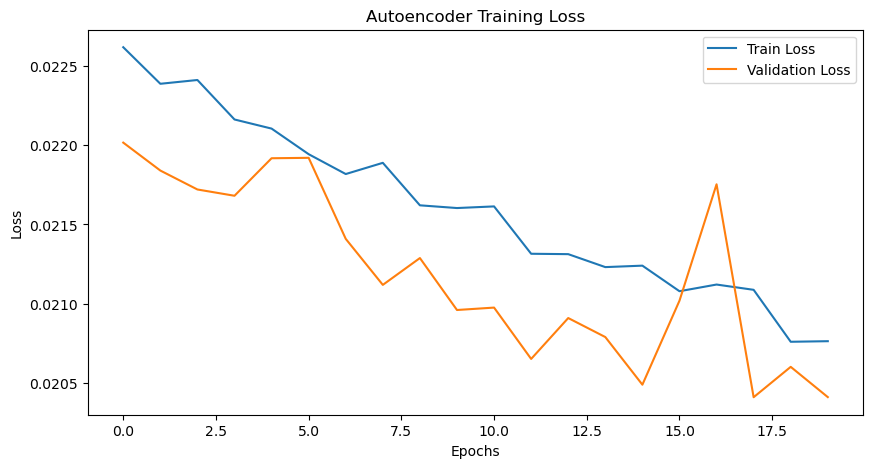

In [37]:
# Autoencoder training loop
print("Starting Autoencoder Training...")
autoencoder_epochs = 20

ae_train_losses = []
ae_val_losses = []

for epoch in range(autoencoder_epochs):
    running_loss = 0.0
    ldm.train()
    # Training loop
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        autoencoder_optimizer.zero_grad()
        recon = ldm.autoencoder_forward(batch)
        #print(batch.size(),recon.size())
        loss = loss_fn(recon, batch)
        loss.backward()
        autoencoder_optimizer.step()
        running_loss += loss.item()
        
    
    # Validation loop
    ldm.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            recon = ldm.autoencoder_forward(batch)
            val_loss += loss_fn(recon, batch).item()
            num_val_batches += 1
    
    
    avg_val_loss = val_loss/num_val_batches
    print(f'Epoch {epoch+1} Validation Loss: {avg_val_loss:.6f}')
    # Plot images input and reconstruction
    if epoch%5==0:
        plot_images(batch)
        # Plot the latent space
        z = ldm.encoder(batch)
        plot_images(z)
        plot_images(recon)
    print('-'*50)
    ae_train_losses.append(running_loss / len(train_loader))
    ae_val_losses.append(avg_val_loss)
    autoencoder_scheduler.step(avg_val_loss)




print("Autoencoder Training Completed!")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(ae_train_losses, label='Train Loss')
plt.plot(ae_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()



In [ ]:
print("\nStarting Diffusion Model Training...")

# OVERRIDE 
diffusion_epochs = 100

# Freeze autoencoder weights
ldm.freeze_autoencoder()

# Diffusion training loop
diff_train_losses = []
diff_val_losses = []

for epoch in range(diffusion_epochs):
    running_loss = 0.0
    ldm.train()
    # Training loop
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        diffusion_optimizer.zero_grad()
        t = diffusion.sample_timesteps(batch.shape[0]).to(device)
        output = ldm(batch, t)
        loss = loss_fn(output, batch)
        loss.backward()
        diffusion_optimizer.step()
        running_loss += loss.item()
        
    
    # Validation loop
    ldm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            t = diffusion.sample_timesteps(batch.shape[0]).to(device)
            output = ldm(batch, t)
            val_loss += loss_fn(output, batch).item()
    
    avg_val_loss = val_loss / len(val_loader)
    diff_val_losses.append(avg_val_loss)
    # Plot images
    if epoch%10==0:
        print(f"Epoch {epoch}")
        plot_images(batch)
        plot_images(output)
    print(f"Epoch {epoch} Avg val loss:{avg_val_loss}, lr = {diffusion_optimizer.param_groups[0]['lr']:.6f}")
    diff_train_losses.append(running_loss / len(train_loader))
    print('-'*50)
    diffusion_scheduler.step(avg_val_loss)
    



print("Diffusion Model Training Completed!")

# Plot the losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ae_val_losses, label='Validation Loss')
plt.title('Autoencoder Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diff_val_losses, label='Validation Loss')
plt.title('Diffusion Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Starting Diffusion Model Training...


# Cold diff LDM

In [21]:
# Functions for pixellation

def upsample_nearest(image, new_width, new_height):

    old_height, old_width = image.shape[-2:]
    scale_x = new_width / old_width
    scale_y = new_height / old_height

    # Create the coordinate grid for the new image
    x_indices = (np.arange(new_width) / scale_x).astype(int)
    y_indices = (np.arange(new_height) / scale_y).astype(int)

    # Use advanced indexing to map the input pixels to the new grid
    upsampled_image = image[:,y_indices[:, None], x_indices]
    return upsampled_image

def downsample_to_fixed_size(image, target_size):

    num_channels, input_height, input_width = image.shape
    target_rows, target_cols = target_size

    # Calculate the scaling factors
    row_scale = input_height / target_rows
    col_scale = input_width / target_cols

    # Create an empty array for the downsampled image
    downsampled_image = np.zeros((num_channels,target_rows, target_cols), dtype=np.float32)

    for row in range(target_rows):
        for col in range(target_cols):
            # Determine the boundaries of the region in the original image
            row_start = int(row * row_scale)
            row_end = int((row + 1) * row_scale)
            col_start = int(col * col_scale)
            col_end = int((col + 1) * col_scale)

            # Extract the region and compute the average for each channel
            region = image[:,row_start:row_end, col_start:col_end]
            downsampled_image[:,row, col] = region.mean(axis=(1, 2))

    return downsampled_image.astype(image.dtype)

# Taken from https://github.com/hendrycks/robustness/blob/master/ImageNet-C/imagenet_c/imagenet_c/corruptions.py
def snow(x0, severity=1):
    c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
         (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
         (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
         (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
         (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

    x0 = np.array(x0, dtype=np.float32) / 255.
    snow_layer = np.random.normal(size=x0.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

    #snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = np.clip((snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8)

    #snow_layer.motion_blur(radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                              cv2.IMREAD_UNCHANGED) / 255.
    snow_layer = snow_layer[..., np.newaxis]

    x0 = c[6] * x0 + (1 - c[6]) * np.maximum(x0, cv2.cvtColor(x0, cv2.COLOR_RGB2GRAY).reshape(224, 224, 1) * 1.5 + 0.5)
    return np.clip(x0 + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255





In [43]:
class coldDiff:
    def __init__(self, steps=300, size=28, loss_type='L2',degradation_type='blur'):
    
        self.steps = steps
        self.size = size
        self.loss_type = loss_type

        self.beta_schedule = self.get_beta_schedule(self.steps)
        self.alpha = 1.0 - self.beta_schedule
        alphas = torch.cat([torch.tensor([1.]), self.alpha])  # Add a leading 1.0 to the alphas tensor
        self.alpha_hat = torch.cumprod(alphas, dim=0).to(device)

        # Degradation type can be 'blur', 'pixellate', 'inpainting' or 'snow'
        if degradation_type == 'blur':
            self.degradation = self.blur
        elif degradation_type == 'pixellate':
            self.degradation = self.pixellate
        elif degradation_type == 'inpainting':
            self.degradation = self.inpainting
        elif degradation_type == 'snow':
            self.degradation = self.snow
        elif degradation_type == 'gaussian':
            self.degradation = self.gaussian_noise
        else:
            raise ValueError("Invalid degradation type. Choose from 'blur', 'pixellate', 'inpainting' or 'snow'.")

    # SAMPLING FUNCTIONS
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,)) #Should this be self.steps+1?
    
    def sample(self, model, batch_size,initial_image='real_degraded', data_loader=None, gmm=None):
        output_shape = (batch_size, 1, 28, 28)
        t = self.steps
        with torch.no_grad():
            model.eval()
            #x_prev = x_t
            # black image
            if initial_image == 'black':
                x_prev = torch.zeros(output_shape).to(device)

            if initial_image == 'random':
                # random and degraded
                dummy_x0 = torch.randn(output_shape).to(device)  # Or: real_batch_from_train_loader
                timestep_tensor = torch.tensor([self.steps] * batch_size).to(device)
                x_prev = self.degradation(dummy_x0, timestep_tensor)\
            
            if initial_image == 'real_degraded':
                if data_loader is None:
                    raise ValueError("data_loader is not provided. Please provide a DataLoader for sampling.")
                real_batch, _ = next(iter(data_loader))  # get real MNIST digits
                real_batch = real_batch.to(device)
                real_batch = real_batch[:batch_size]  # in case batch size mismatch
                timestep_tensor = torch.tensor([self.steps] * real_batch.shape[0]).to(device)
                x_prev = self.degradation(real_batch, timestep_tensor)

            if initial_image == 'gmm':
                # Gaussian Mixture Model
                if gmm is None:
                    raise ValueError("GMM is not provided. Please provide a GMM model for sampling.")
                # Sample from the GMM
                gmm_samples, _ = gmm.sample(batch_size)  # Sample from the GMM
                gmm_samples = gmm_samples.astype(np.float32)
                gmm_samples = torch.from_numpy(gmm_samples)  # Convert to tensor
                gmm_samples = gmm_samples.view(batch_size, 1, self.size, self.size)  # Reshape to the desired output shape
                gmm_samples = gmm_samples.to(device)  # Move to the appropriate device
                # Set the initial image to the GMM samples
                x_prev = gmm_samples
                
                


            for s in range(t, 0, -1):
                s_ = (torch.ones(batch_size)*s).long().to(device)
                pred_x0 = model(x_prev, s_)
                x_prev = x_prev - self.degradation(pred_x0, s_) + self.degradation(pred_x0, s_-1)
        return x_prev

    def sample_ddpm(self, model, batch_size):
        model.eval()
        # Algo 2 - Sampling
        with torch.no_grad():
            x = torch.randn((batch_size, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(batch_size) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i>1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1/torch.sqrt(alpha)*(x-((1-alpha)/torch.sqrt(1-alpha_hat))*predicted_noise)+torch.sqrt(beta)*noise
            model.train()
            x = (x.clamp(-1,1)+1)/2
            x = (x*255).type(torch.uint8)
            return x

    # Normal gaussian noise degradation
    def gaussian_noise(self, x0, t):
        """if len(t.shape) == 1:
            t = t[:, None, None, None]

        sqrt_alpha_bar = self.alpha_bar[t.squeeze().long().clamp(max=self.steps)].sqrt().to(x0.device)[:, None, None, None]
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bar[t.squeeze().long().clamp(max=self.steps)]).sqrt().to(x0.device)[:, None, None, None]

        noise = torch.randn_like(x0)
        
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
        """
        

        e = torch.randn_like(x0)
        x_t = x0*torch.sqrt(self.alpha_hat[t])[:, None, None, None] + torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]*e 
        return x_t

   

    # DEGRADATION FUNCTIONS
    def blur(self, x0, t, base_sigma=1):
        sigma_t = torch.sqrt(t*base_sigma**2).detach().cpu().numpy()
        x0_cpu = x0.detach().cpu().numpy()
        blurred_imgs = [gaussian_filter(x0_cpu[i], sigma=(0, sigma_t[i], sigma_t[i])) for i in range(len(sigma_t))]
        return torch.from_numpy(np.stack(blurred_imgs)).to(device)
        # return GaussianBlur(5, sigma_t)

    def pixellate(self,x0,t,final_resolution=4): # Super resolution in the paper

        original_w,original_h = x0.shape[2],x0.shape[3]
                
        w,h = original_w,original_h
        pixellated_imgs = x0.detach().cpu().numpy()

        # Convert to list of numpy arrays
        pixellated_imgs = [pixellated_imgs[i].astype(np.float32) for i in range(len(pixellated_imgs))]
        while w > final_resolution and h > final_resolution:
            if(w//2 < final_resolution and h//2 < final_resolution):
                target_width = final_resolution
                target_height = final_resolution
            else:
                target_width = w//2
                target_height = h//2
            # Downsample the image using average pooling
            for i in range(len(pixellated_imgs)):
                if t[i] > 0:
                    
                    pixellated_imgs[i] = downsample_to_fixed_size(pixellated_imgs[i], (target_height, target_width))
                    #print(f"pixellated_imgs[{i}].shape:{pixellated_imgs[i].shape}, target_width:{target_width}, target_height:{target_height}")
             
            w,h = w//2,h//2
            
            t = t - 1    
        # Up sample the image to the original resolution (original_w,original_h) using nearest neighbour interpolation

        pixellated_imgs = [upsample_nearest(pixellated_imgs[i], original_w, original_h) for i in range(len(pixellated_imgs))]


        return torch.from_numpy(np.stack(pixellated_imgs)).to(device)
    
    def inpainting(self,x0,t,base_variance=1): #Base variance is beta in the paper
        w,h = x0.shape[2],x0.shape[3]
        center_x,center_y = np.random.randint(0,w, size = x0.shape[0]),np.random.randint(0,h,x0.shape[0])
        variance = base_variance + 0.5*t.detach().cpu().numpy()
        # 2d gaussian curve with center at rand_x,rand_y and peak value = 1, discretized 

        x0 = x0.detach().cpu().numpy()
        gaussian_mask = np.zeros_like(x0, dtype=float)

        y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        gaussian = np.stack([np.exp(-((x - center_x[i])**2 + (y - center_y[i])**2) / (2 * variance[i])) for i in range(len(x0))])
        gaussian = 1 - gaussian

        # Normalize the gaussian mask
        gaussian = gaussian / np.max(gaussian, axis=(1,2), keepdims=True)

        # Add extra channel dimension as 2nd dimension
        gaussian = gaussian[:,None,:,:]
    
        # Apply the mask to the image
        inpainted_imgs = x0 * gaussian
     
        return torch.from_numpy(inpainted_imgs).float().to(device)

    def snow(self,x0, severity=1):
        c = [(0.1, 0.3, 3, 0.5, 10, 4, 0.8),
            (0.2, 0.3, 2, 0.5, 12, 4, 0.7),
            (0.55, 0.3, 4, 0.9, 12, 8, 0.7),
            (0.55, 0.3, 4.5, 0.85, 12, 8, 0.65),
            (0.55, 0.3, 2.5, 0.85, 12, 12, 0.55)][severity - 1]

        x0 = x0.detach().cpu().numpy() / 255.
    
        snow_layer = np.random.normal(size=x0.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

        #snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
        snow_layer[snow_layer < c[3]] = 0

        snow_layer = (np.clip(snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8)

        snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                                cv2.IMREAD_UNCHANGED) / 255.
        snow_layer = snow_layer[..., np.newaxis]

        x0 = c[6] * x0 + (1 - c[6]) * np.maximum(x0, cv2.cvtColor(x0, cv2.COLOR_RGB2GRAY).reshape(224, 224, 1) * 1.5 + 0.5)
        snowified_images =  np.clip(x0 + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255
        
        return torch.from_numpy(snowified_images).to(device)

    ## Scheduling 
    def get_beta_schedule(self, timesteps, start=1e-4, end=0.02, schedule_type='linear'):
        if schedule_type == 'linear':
            return torch.linspace(start, end, timesteps)
        elif schedule_type == 'cosine':
            steps = torch.arange(timesteps + 1, dtype=torch.float32)
            f = lambda t: torch.cos(((t / timesteps) + 0.008) / 1.008 * torch.pi / 2) ** 2
            alphas_bar = f(steps) / f(torch.tensor(0.0))
            betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
            return torch.clip(betas, 1e-5, 0.999)
        else:
            raise ValueError("Unknown schedule type")

    

    


## Function to plot images

In [35]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.detach().cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

## Other helpers

In [36]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.Resize((28, 28)),    # Resize to 28x28 for MNIST
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [37]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

# Training setup

In [44]:
# Initialize model



encoder = Encoder(in_channels=1,latent_channels=latent_channels).to(device)
decoder = Decoder(latent_channels=latent_channels,out_channels=1).to(device)
unet = UNet(c_in=latent_channels,c_out=latent_channels).to(device)









# Create optimizer for autoencoder only




In [76]:
autoencoder_epochs = 10
diffusion_epochs = 50

batch_size = 128
image_size = 28
learning_rate = 1e-3
loss_type = 'L1' # 'L1', 'L2', 'SmoothL1', 'Huber'
sampling_type = 'gmm' # 'random', 'black', 'real_degraded', 'gmm'

# DEGRADATION TYPE
degradation_type = 'blur' # 'blur', 'pixellate', 'inpainting', 'snow', 'gaussian'

# Steps for diffusion process - changes based on the function used
# For pixellate, steps = 4 (MNIST) or 6 (CIFAR10)
steps = 50

FASHION_MNIST = False

# Import dataset
if (FASHION_MNIST):
    dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transforms, download=True)
else:
    dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

# LIMIT THE DATASET
LIMIT = True
if LIMIT:
    num_samples = 6000
    dataset = torch.utils.data.Subset(dataset, range(num_samples))
    test_dataset = torch.utils.data.Subset(test_dataset, range(num_samples//6))

    print("LIMITED DATASET")
    print(len(dataset))
    print(len(test_dataset))

else:
    print("FULL DATASET")
    print(len(dataset))
    print(len(test_dataset))
# dataset = torch.utils.data.Subset(dataset, range(1000))
# test_dataset = torch.utils.data.Subset(test_dataset, range(1000))


train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)

diffusion = coldDiff(size=image_size, steps = steps, degradation_type=degradation_type)
ldm = LatentDiffusionModel(encoder, decoder, unet, diffusion).to(device)

autoencoder_optimizer = torch.optim.Adam(
    list(ldm.encoder.parameters()) + list(ldm.decoder.parameters()),
    lr=1e-3)

diffusion_optimizer = torch.optim.Adam(ldm.unet.parameters(), lr=1e-3)

# Create optimizer for diffusion model only

autoencoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(autoencoder_optimizer, factor=0.5, patience=5)
diffusion_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(diffusion_optimizer, factor=0.5, patience=5)



if loss_type == 'L1':
    loss_fn = nn.L1Loss()
elif loss_type == 'L2':
    loss_fn = nn.MSELoss()
elif loss_type == 'SmoothL1':
    loss_fn = nn.SmoothL1Loss()
elif loss_type == 'Huber':
    loss_fn = nn.HuberLoss()
elif loss_type == 'BCE':
    loss_fn = nn.BCEWithLogitsLoss()
else:
    raise ValueError("Invalid loss type. Choose from 'L1', 'L2', 'SmoothL1', 'Huber' or 'BCE'.")

reconstruction_loss = nn.MSELoss()

length = len(train_loader)
print(length)

train_losses = []
val_losses = []



LIMITED DATASET
6000
1000
47


# Visualize degradations

In [83]:
import matplotlib.pyplot as plt

# z is your latent of shape (4, 8, 8)
def plot_latent(z):
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for i in range(4):
        axes[i].imshow(z[i], cmap='viridis')  # or 'gray', 'magma' etc.
        axes[i].axis('off')
        axes[i].set_title(f'Channel {i}')
    plt.tight_layout()
    plt.show()


torch.Size([1, 28, 28])
tensor([35, 41, 17, 17, 18, 41, 29, 25, 23, 41, 49,  3, 46, 31,  7, 30]) torch.Size([16])


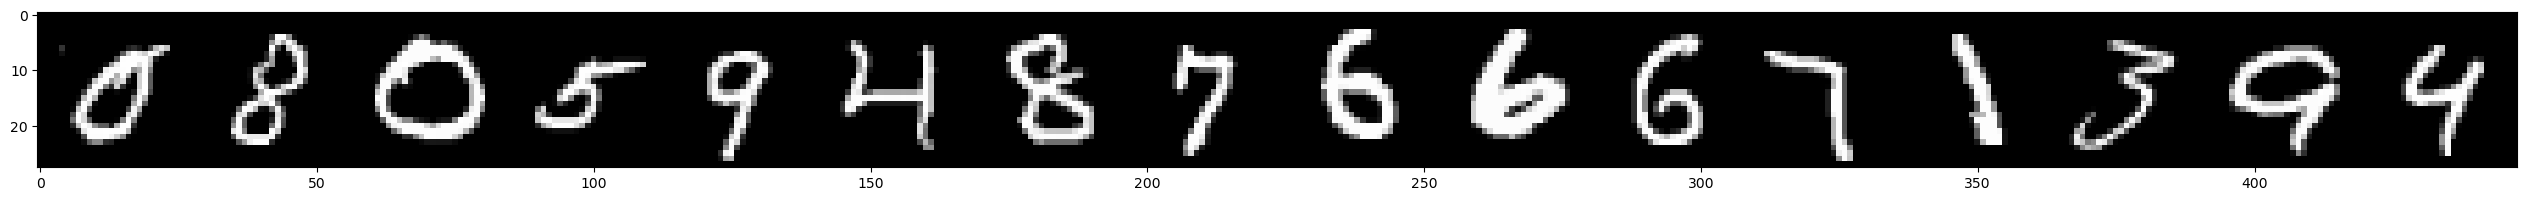

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 8, 8])


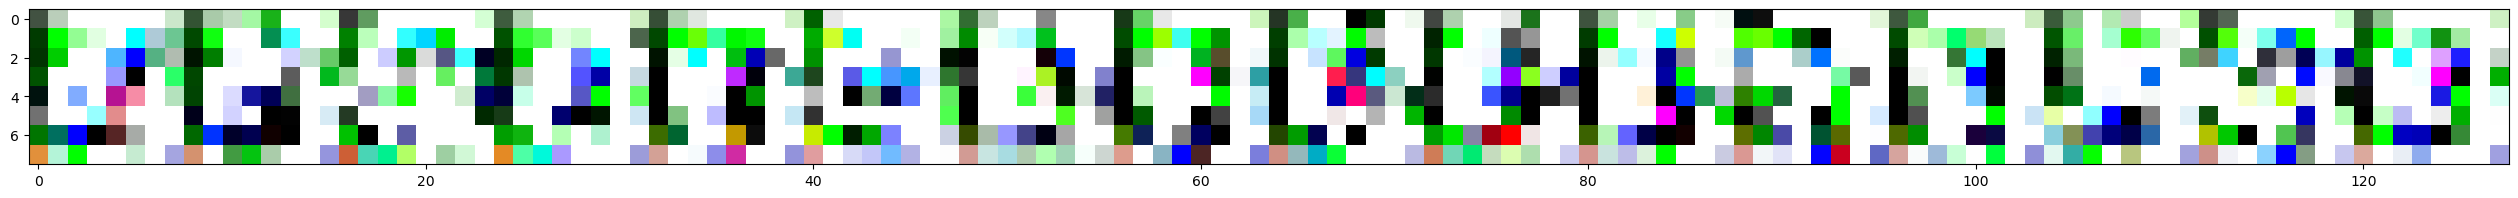

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


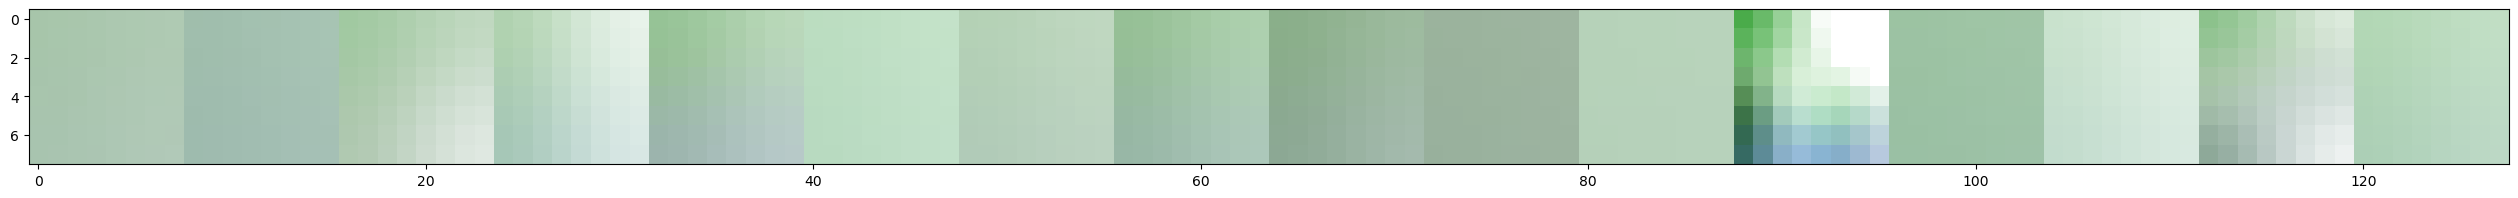

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


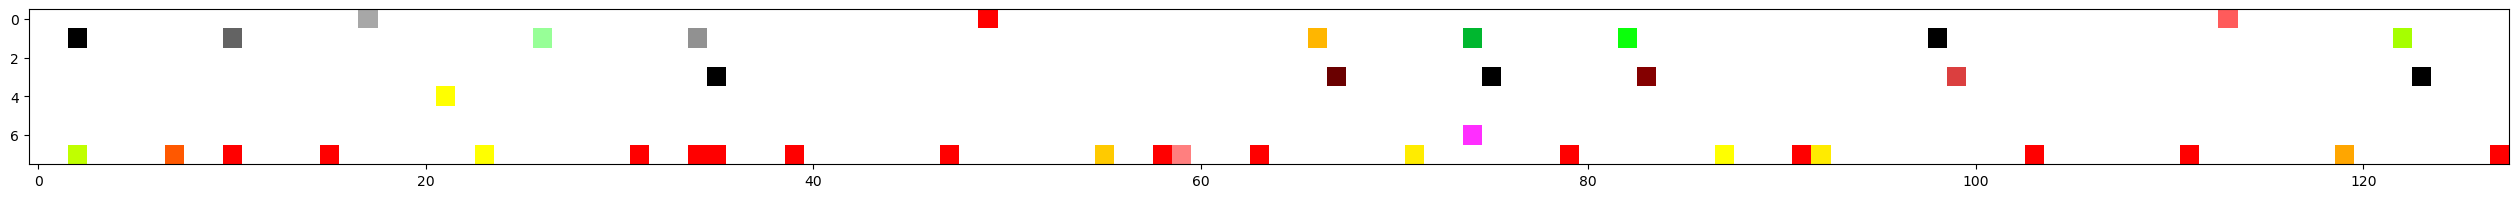

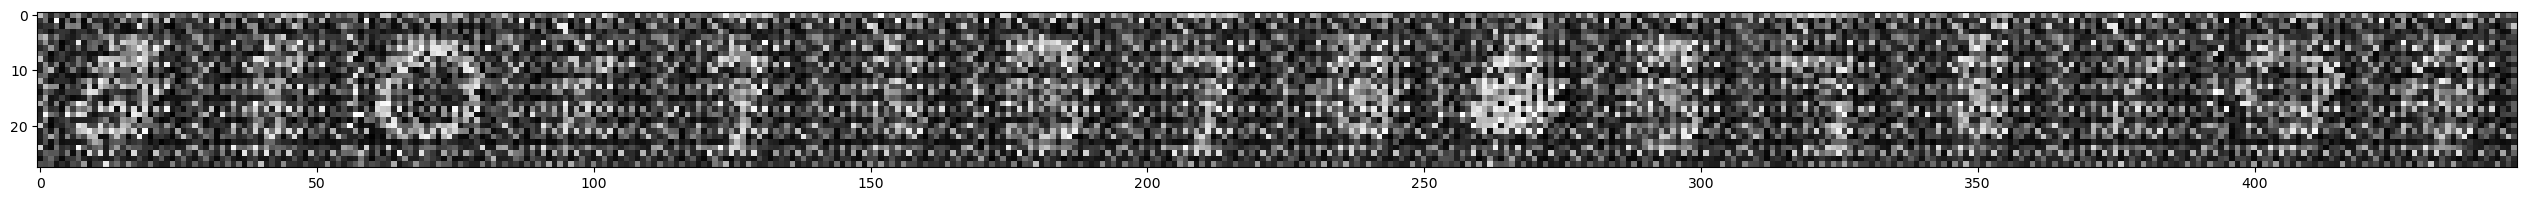

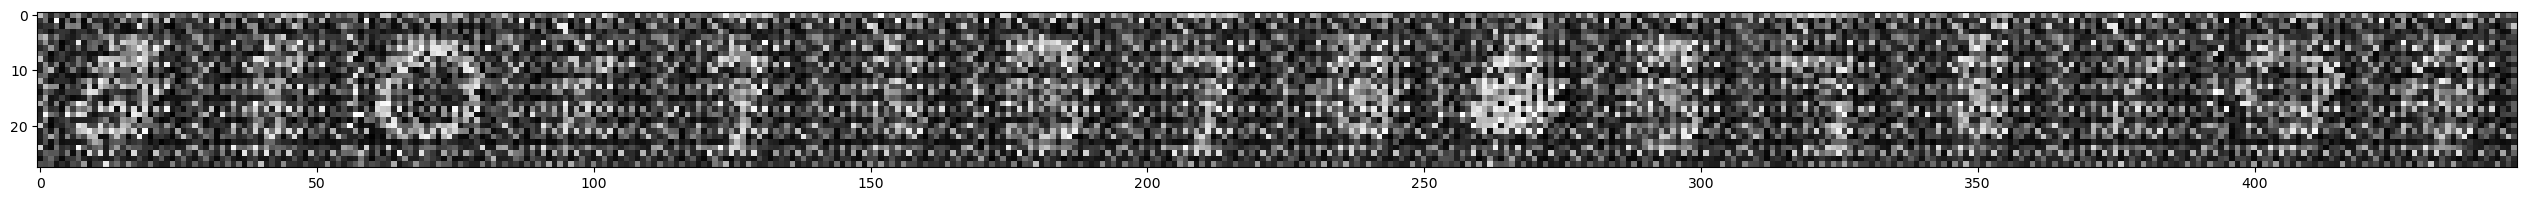

In [82]:
MAX_DISPLAY_IMAGES = 16

for x, _ in train_loader:
    x = x.to(device)
    x = x[:MAX_DISPLAY_IMAGES]  
    t = diffusion.sample_timesteps(x.shape[0])
    print(x[0].shape)
    print(t,t.shape)
    # Plot the images
    
    plot_images(x)

    z = ldm.encode(x)
    
    plot_images(z)

    z_noised = ldm.diffusion.degradation(z,t)
    plot_images(z_noised)


    z_denoised = ldm.unet(z_noised,t)
    plot_images(z_denoised)

    x_recon = ldm.decoder(z_denoised)
    plot_images(x_recon)



    x_t = ldm(x,t)


    plot_images(x_t)
    break

# Training loop


Starting Cold Diffusion Model Training...


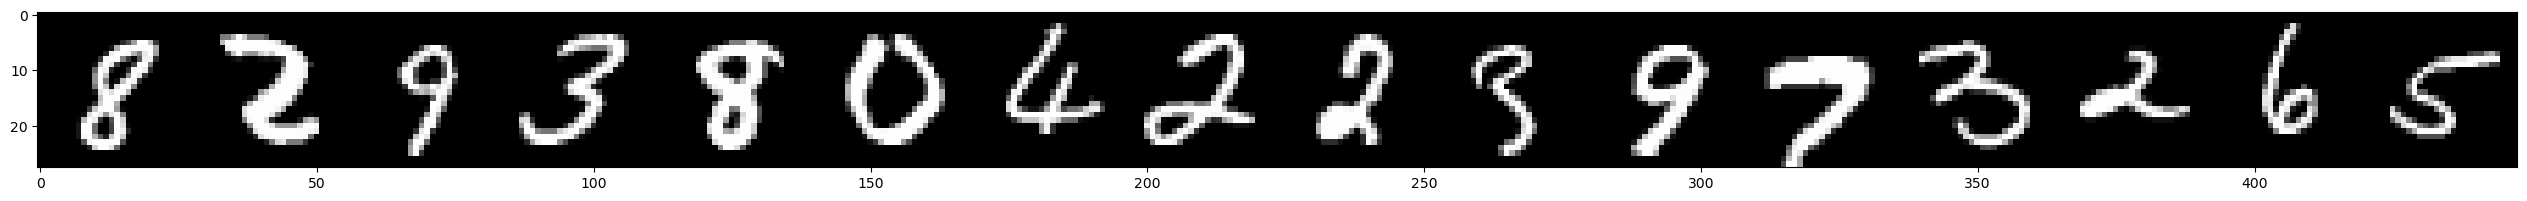

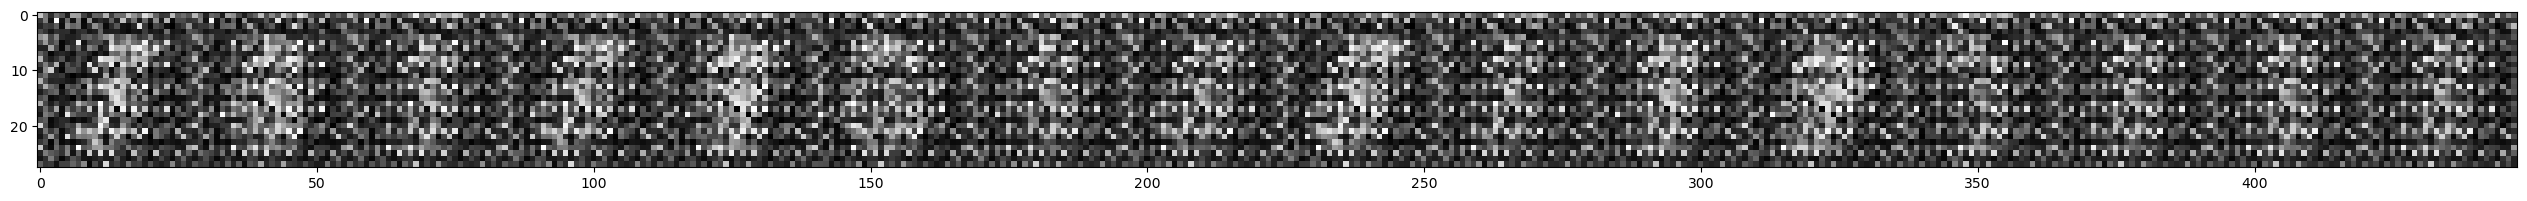

Epoch 0 Avg val loss:0.6225844166780773
--------------------------------------------------
Epoch 1 Avg val loss:0.6214033020170111
--------------------------------------------------
Epoch 2 Avg val loss:0.6209658588233747
--------------------------------------------------
Epoch 3 Avg val loss:0.6184708711348081
--------------------------------------------------
Epoch 4 Avg val loss:0.6167545569570441
--------------------------------------------------
Epoch 5 Avg val loss:0.6166526769336901
--------------------------------------------------
Epoch 6 Avg val loss:0.6175454274604195
--------------------------------------------------
Epoch 7 Avg val loss:0.6151836749754453
--------------------------------------------------
Epoch 8 Avg val loss:0.6150338085074174
--------------------------------------------------
Epoch 9 Avg val loss:0.6141514605597446
--------------------------------------------------


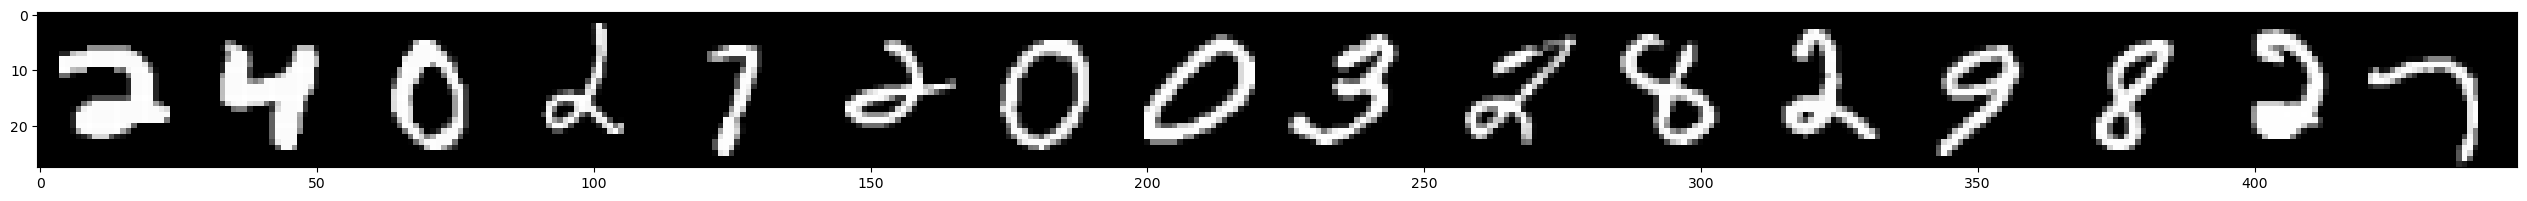

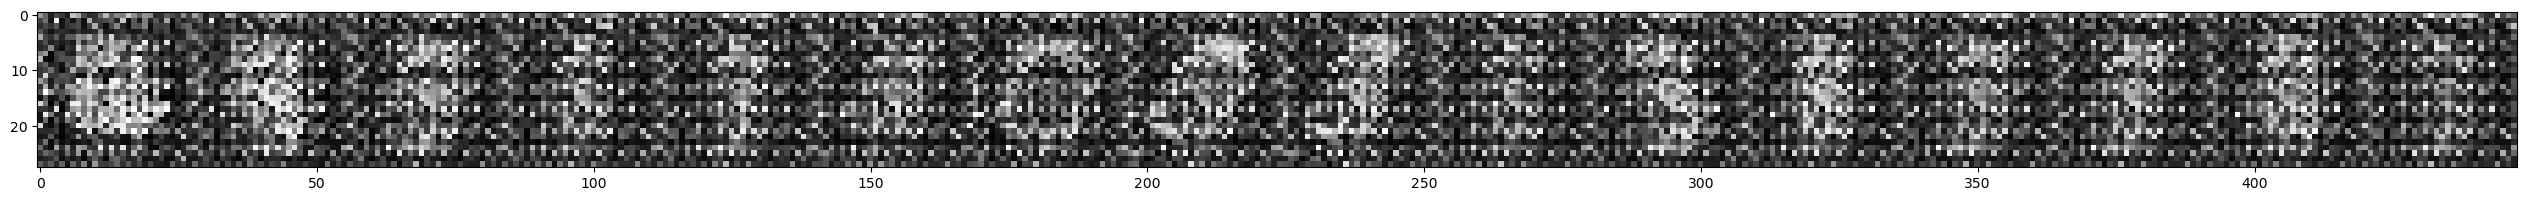

Epoch 10 Avg val loss:0.6135518237164146
--------------------------------------------------
Epoch 11 Avg val loss:0.6122336779770098
--------------------------------------------------
Epoch 12 Avg val loss:0.6127492220778215
--------------------------------------------------
Epoch 13 Avg val loss:0.6125899427815488
--------------------------------------------------
Epoch 14 Avg val loss:0.6120534601964449
--------------------------------------------------
Epoch 15 Avg val loss:0.611820261729391
--------------------------------------------------
Epoch 16 Avg val loss:0.6124484460604819
--------------------------------------------------
Epoch 17 Avg val loss:0.6109788417816162
--------------------------------------------------
Epoch 18 Avg val loss:0.6099687610801897
--------------------------------------------------
Epoch 19 Avg val loss:0.6113525331020355
--------------------------------------------------


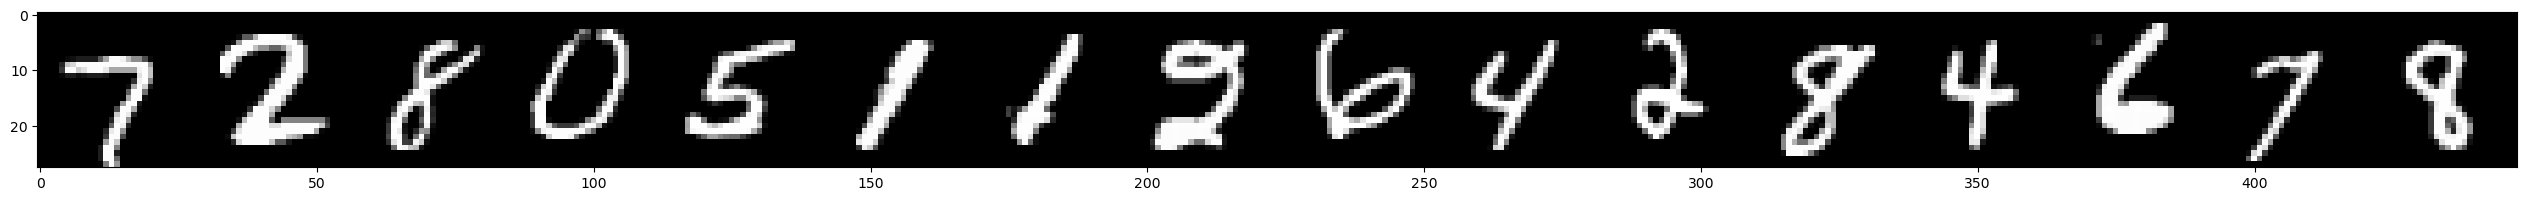

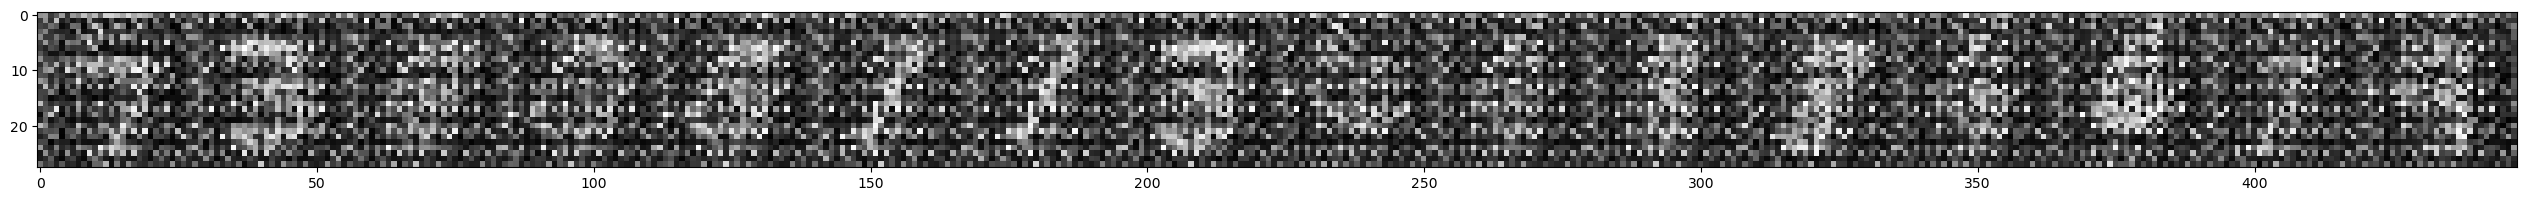

Epoch 20 Avg val loss:0.613470827278338
--------------------------------------------------
Epoch 21 Avg val loss:0.6094882786273956
--------------------------------------------------
Epoch 22 Avg val loss:0.6092512387978403
--------------------------------------------------
Epoch 23 Avg val loss:0.6081888456093637
--------------------------------------------------
Epoch 24 Avg val loss:0.6080006784514377
--------------------------------------------------
Epoch 25 Avg val loss:0.6082718952705986
--------------------------------------------------
Epoch 26 Avg val loss:0.6086916688241457
--------------------------------------------------
Epoch 27 Avg val loss:0.6078196638508847
--------------------------------------------------
Epoch 28 Avg val loss:0.6063901750664962
--------------------------------------------------
Epoch 29 Avg val loss:0.6066497611372095
--------------------------------------------------


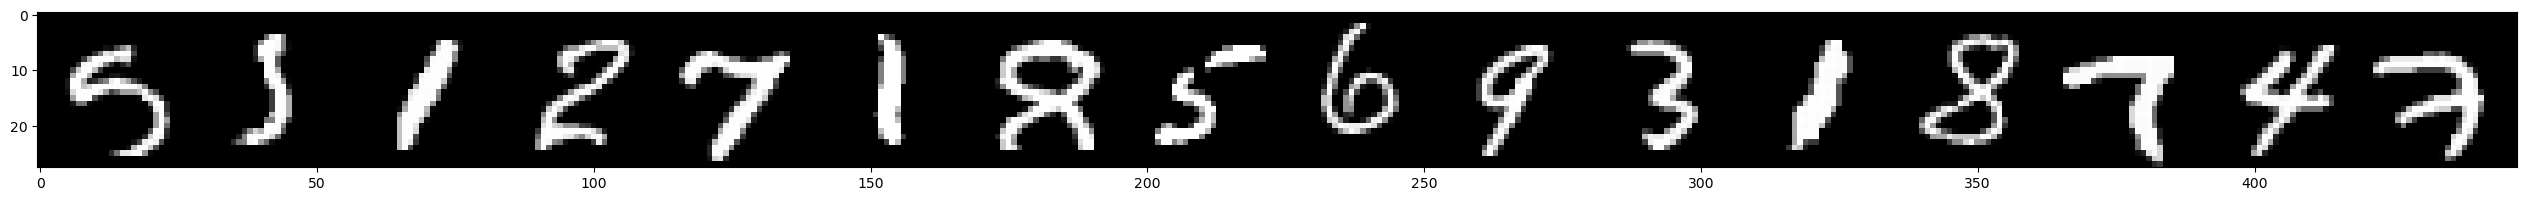

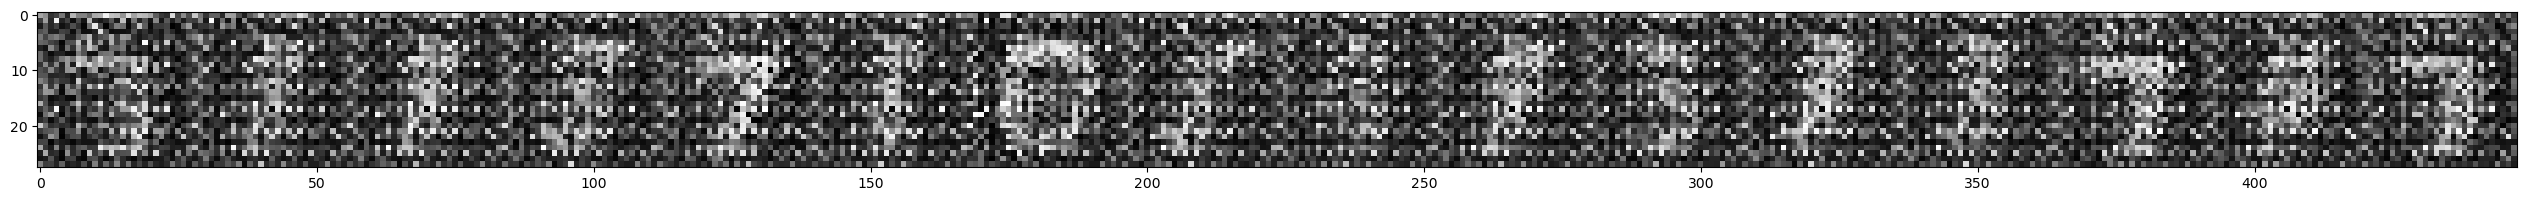

Epoch 30 Avg val loss:0.6065731785799328
--------------------------------------------------
Epoch 31 Avg val loss:0.6061045417660161
--------------------------------------------------
Epoch 32 Avg val loss:0.606303732646139
--------------------------------------------------
Epoch 33 Avg val loss:0.6057973896202288
--------------------------------------------------
Epoch 34 Avg val loss:0.6056952680412092
--------------------------------------------------
Epoch 35 Avg val loss:0.6058957200301321
--------------------------------------------------
Epoch 36 Avg val loss:0.6051482997442547
--------------------------------------------------
Epoch 37 Avg val loss:0.6055084592417667
--------------------------------------------------
Epoch 38 Avg val loss:0.6041983836575558
--------------------------------------------------
Epoch 39 Avg val loss:0.6043729374283239
--------------------------------------------------


KeyboardInterrupt: 

In [75]:
print("\nStarting Cold Diffusion Model Training...")

# Step 2: Train Diffusion Model
# Freeze autoencoder weights
ldm.freeze_autoencoder()

# Diffusion training loop
diff_train_losses = []
diff_val_losses = []

for epoch in range(diffusion_epochs):
    running_loss = 0.0
    ldm.train()
    # Training loop
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        diffusion_optimizer.zero_grad()
        t = diffusion.sample_timesteps(batch.shape[0]).to(device)
        output = ldm(batch, t)
        loss = loss_fn(output, batch)
        loss.backward()
        diffusion_optimizer.step()
        running_loss += loss.item()
        
    
    # Validation loop
    ldm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            t = diffusion.sample_timesteps(batch.shape[0]).to(device)
            output = ldm(batch, t)
            val_loss += loss_fn(output, batch).item()
    
    avg_val_loss = val_loss / len(val_loader)
    diff_val_losses.append(avg_val_loss)
    # Plot images
    if epoch%10==0:
        plot_images(batch)
        plot_images(output)
    print(f"Epoch {epoch} Avg val loss:{avg_val_loss}")
    print('-'*50)



print("Diffusion Model Training Completed!")

# Plot the losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ae_val_losses, label='Validation Loss')
plt.title('Autoencoder Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diff_val_losses, label='Validation Loss')
plt.title('Diffusion Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()